In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
from prettytable import PrettyTable
import numpy as np
# Sklearn model delection
from sklearn.model_selection import RandomizedSearchCV
# Sklearn metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, accuracy_score
# Sklearn models
from sklearn.linear_model import Lasso, ElasticNet, Ridge, SGDRegressor
from sklearn.svm import SVR, NuSVR
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.linear_model import LinearRegression

import random

%matplotlib inline

# Make results reproducible
random.seed(100)

In [0]:
import pandas as pd


class Dataloader(): 
    def __init__(self, csv_path):
      #  Initialize Bike Sharing Dataset dataloader.  
        self.csv_path = csv_path
        self.data = pd.read_csv(self.csv_path)
        # Shuffle
        #self.data.sample(frac=1.0, replace=True, random_state=30)
      #init cannot return value so getFullData() function is written
    def getFullData(self):
        return self.data
    def getData(self):
        # Split data into train and validation(test) set with 70:30 ratio
        split_train = int(0.8 * len(self.data)) 
        train = self.data[:split_train]
        val = self.data[split_train:]
        return train, val

## Descriptive Analysis

split dataset into training, validation, and testing:

In [0]:
dataloader = Dataloader('/content/drive/My Drive/AI ML/Project_2/Project_2/Dataset/hour.csv')

fullData = dataloader.getFullData()
train, val = dataloader.getData()
category_features = ['season', 'holiday', 'mnth', 'hr', 'weekday', 'workingday', 'weathersit']
number_features = ['temp', 'atemp', 'hum', 'windspeed']

features= category_features + number_features
target = ['cnt']

Get column names

In [0]:
list(fullData.columns)

['instant',
 'dteday',
 'season',
 'yr',
 'mnth',
 'hr',
 'holiday',
 'weekday',
 'workingday',
 'weathersit',
 'temp',
 'atemp',
 'hum',
 'windspeed',
 'casual',
 'registered',
 'cnt']

first 5 rows of the dataset

In [0]:
fullData.head(5)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


data statistics



In [0]:
fullData.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


In [0]:
for col in category_features:
    fullData[col] = fullData[col].astype('category')
fullData[category_features].describe()

,season,holiday,mnth,hr,weekday,workingday,weathersit
count,17379,17379,17379,17379,17379,17379,17379
unique,4,2,12,24,7,2,4
top,3,0,7,17,6,1,1
freq,4496,16879,1488,730,2512,11865,11413


## Missing Value Analysis

Check any NULL values in data:

In [0]:
print(fullData.isnull().any())

instant       False
dteday        False
season        False
yr            False
mnth          False
hr            False
holiday       False
weekday       False
workingday    False
weathersit    False
temp          False
atemp         False
hum           False
windspeed     False
casual        False
registered    False
cnt           False
dtype: bool


## Outlier Analysis

### Box plots

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Temperature'),
 Text(0.5, 1.0, 'Box Plot On Count Across Temperature')]

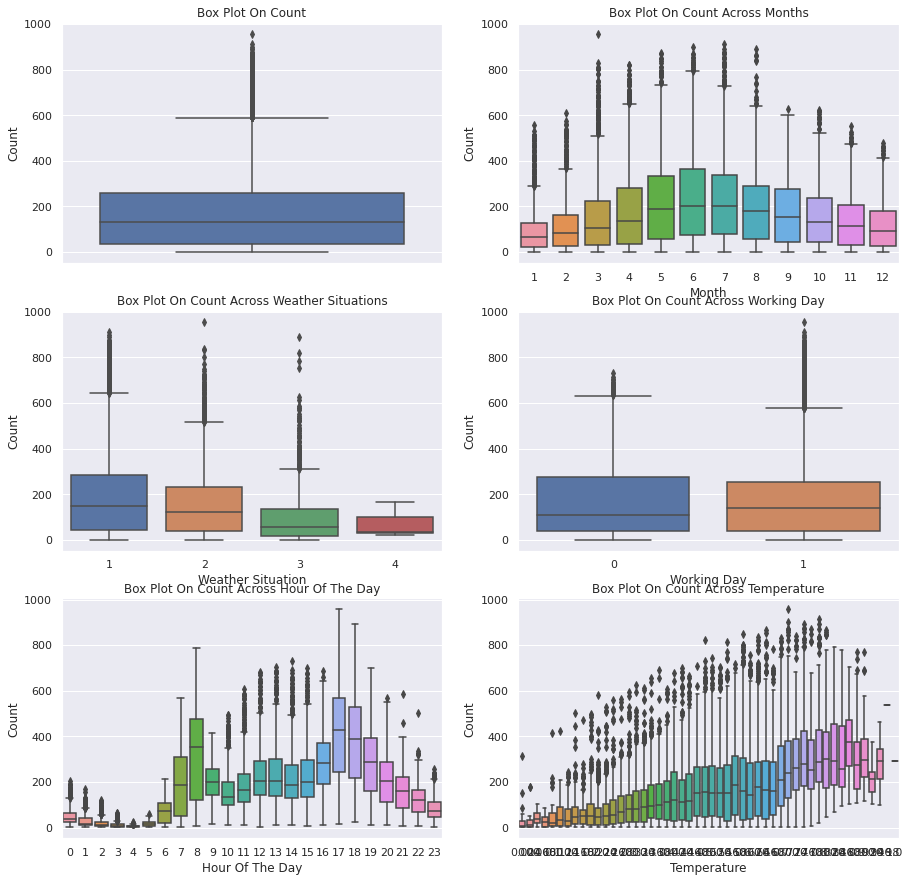

In [0]:
sns.set(font_scale=1.0)
fig, axes = plt.subplots(nrows=3,ncols=2)
fig.set_size_inches(15, 15)
sns.boxplot(data=train,y="cnt",orient="v",ax=axes[0][0])
sns.boxplot(data=train,y="cnt",x="mnth",orient="v",ax=axes[0][1])
sns.boxplot(data=train,y="cnt",x="weathersit",orient="v",ax=axes[1][0])
sns.boxplot(data=train,y="cnt",x="workingday",orient="v",ax=axes[1][1])
sns.boxplot(data=train,y="cnt",x="hr",orient="v",ax=axes[2][0])
sns.boxplot(data=train,y="cnt",x="temp",orient="v",ax=axes[2][1])

axes[0][0].set(ylabel='Count',title="Box Plot On Count")
axes[0][1].set(xlabel='Month', ylabel='Count',title="Box Plot On Count Across Months")
axes[1][0].set(xlabel='Weather Situation', ylabel='Count',title="Box Plot On Count Across Weather Situations")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count Across Working Day")
axes[2][0].set(xlabel='Hour Of The Day', ylabel='Count',title="Box Plot On Count Across Hour Of The Day")
axes[2][1].set(xlabel='Temperature', ylabel='Count',title="Box Plot On Count Across Temperature")


__Interpretation:__ The working day and holiday box plot indicates that more bicycles are rent during normal working days than on weekends or holidays. The hourly box plots show a local maximum at 8 am and one at 5 pm followed by 6 pm which indicates that most users of the bicycle rental service use the bikes to get to work or school. Another important factor seems to be the temperature: higher temperatures lead to an increasing number of bike rents and lower temperatures not only decrease the average number of rents but also shows more outliers in the data.

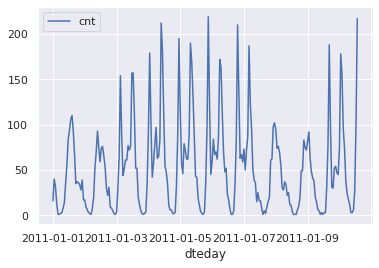

In [0]:
train[:24*10].plot(x='dteday', y='cnt')

[Text(0.5, 1.0, 'Season wise hourly distribution of counts')]

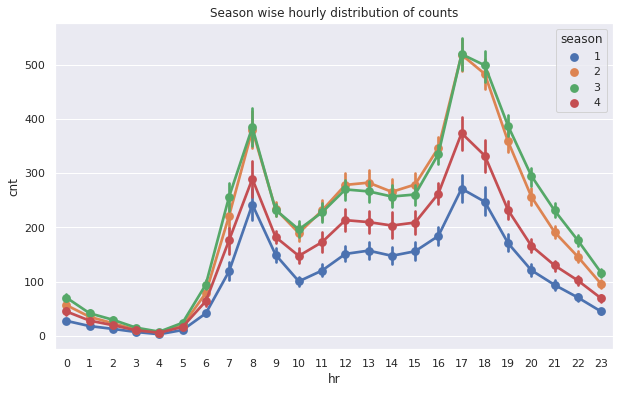

In [0]:
fig,ax = plt.subplots()
fig.set_size_inches(10, 6)
sns.pointplot(data=train[['hr', 'cnt', 'season']],
             x='hr',y='cnt',
             hue='season',ax=ax)
ax.set(title="Season wise hourly distribution of counts")

[Text(0.5, 1.0, 'Weekday wise hourly distribution of counts')]

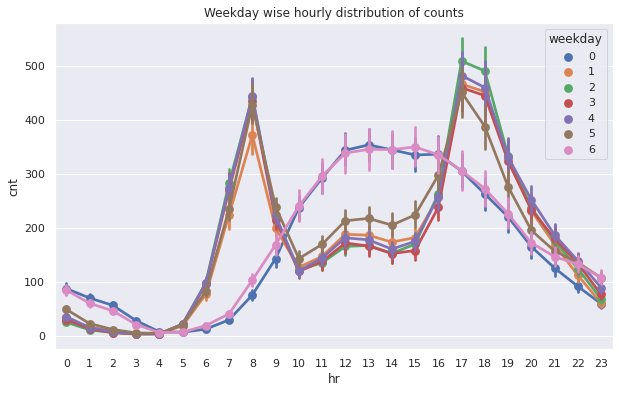

In [0]:
fig,ax = plt.subplots()
fig.set_size_inches(10, 6)
sns.pointplot(data=train[['hr', 'cnt', 'weekday']],
             x='hr',y='cnt',
             hue='weekday',ax=ax)
ax.set(title="Weekday wise hourly distribution of counts")

[Text(0.5, 1.0, 'Monthly distribution of counts')]

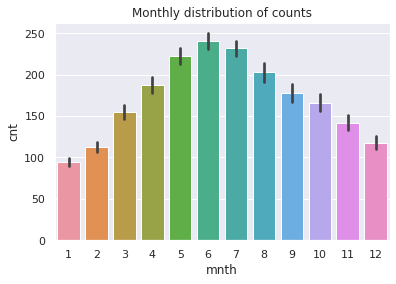

In [0]:
fig,ax = plt.subplots()
sns.barplot(data=train[['mnth',
                         'cnt']],
            x="mnth",y="cnt")
ax.set(title="Monthly distribution of counts")

**Interpretation**: June sees the highest bike users.

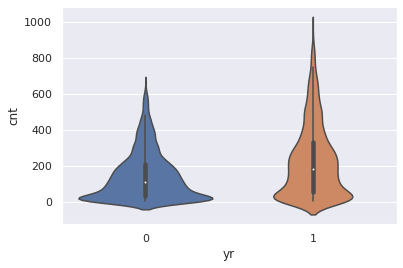

In [0]:
sns.violinplot(data=train[['yr','cnt']],
              x="yr",y="cnt")

fig,ax = plt.subplots()
sns.pointplot(data=train[['hr',
                            'cnt',
                            'weekday']],
             x='hr',y='cnt',
             hue='weekday',ax=ax)
ax.set(title="Weekday wise hourly distribution of counts")

### Remove outliers from data

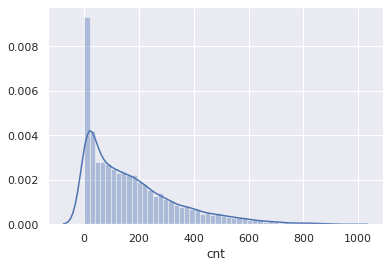

In [0]:
sns.distplot(train[target[-1]]);

The distribution plot of the count values reveals that the count values do not match a normal distribution. We will use the median and interquartile range (IQR) to identify and remove outliers from the data.
source:
https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba

Samples in train set with outliers: 13903
Samples in train set without outliers: 13507


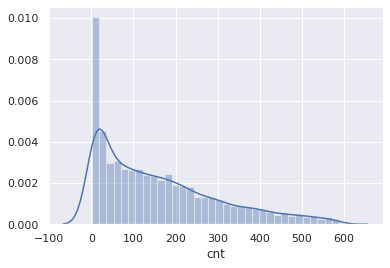

In [0]:
print("Samples in train set with outliers: {}".format(len(train)))
q1 = train.cnt.quantile(0.25)
q3 = train.cnt.quantile(0.75)
iqr = q3 - q1
lower_bound = q1 -(1.5 * iqr) 
upper_bound = q3 +(1.5 * iqr) 
train_preprocessed = train.loc[(train.cnt >= lower_bound) & (train.cnt <= upper_bound)]
print("Samples in train set without outliers: {}".format(len(train_preprocessed)))
sns.distplot(train_preprocessed.cnt);

## Correlation Analysis

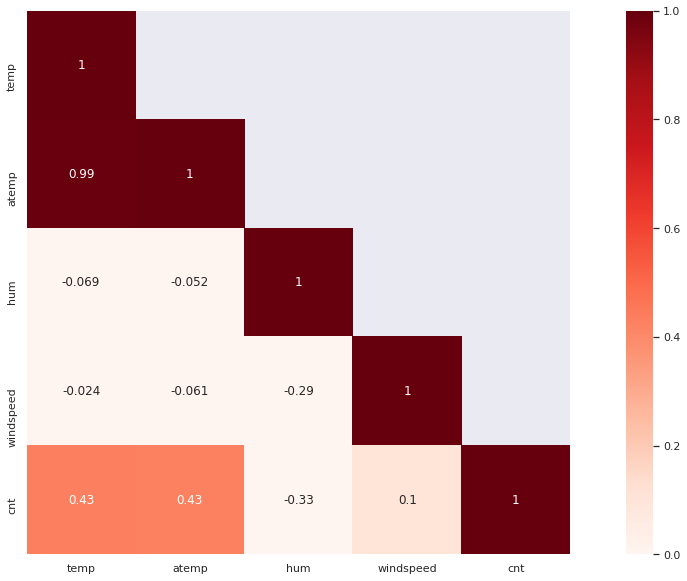

In [0]:
matrix = train[number_features + target].corr()
heat = np.array(matrix)
heat[np.tril_indices_from(heat)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sns.set(font_scale=1.0)
sns.heatmap(matrix, mask=heat,vmax=1.0, vmin=0.0, square=True,annot=True, cmap="Reds")

In [0]:
features.remove('atemp')

## Overview Metrics

### Mean Squared Error (MSE)

MSE = $\sqrt{\frac{1}{N} \sum_{i=1}^N (x_i - y_i)^2}$

### Root Mean Squared Logarithmic Error (RMSLE)

RMSLE = $\sqrt{ \frac{1}{N} \sum_{i=1}^N (\log(x_i) - \log(y_i))^2 }$

### $R^2$ Score

$R^2=1-\frac{\sum_{i=1}^{n}e_i^2}{\sum_{i=1}^{n}(y_i-\bar{y})^2}$

## Model Selection

In [0]:
x_train = train_preprocessed[features].values
y_train = train_preprocessed[target].values.ravel()
# Sort validation set for plots
val = val.sort_values(by=target)
x_val = val[features].values
y_val = val[target].values.ravel()
#x_test = test[features].values

table = PrettyTable()
table.field_names = ["Model", "Mean Squared Error", "R² score"]

models = [
    SGDRegressor(max_iter=1000, tol=1e-3),
    Lasso(alpha=0.1),
    ElasticNet(random_state=0),
    Ridge(alpha=.5),
    SVR(gamma='auto', kernel='linear'),
    SVR(gamma='auto', kernel='rbf'),
    BaggingRegressor(),
    BaggingRegressor(KNeighborsClassifier(), max_samples=0.5, max_features=0.5),
    NuSVR(gamma='auto'),
    RandomForestRegressor( random_state=0, n_estimators=300)
    GradientBoostingRegre
]

for model in models:
    model.fit(x_train, y_train) 
    y_res = model.predict(x_val)

    mse = mean_squared_error(y_val, y_res)
    score = model.score(x_val, y_val)    

    table.add_row([type(model).__name__, format(mse, '.2f'), format(score, '.2f')])

print(table)

+-----------------------+--------------------+----------+
|         Model         | Mean Squared Error | R² score |
+-----------------------+--------------------+----------+
|      SGDRegressor     |      43994.83      |   0.10   |
|         Lasso         |      42248.48      |   0.13   |
|       ElasticNet      |      45205.25      |   0.07   |
|         Ridge         |      42223.36      |   0.13   |
|          SVR          |      48069.17      |   0.01   |
|          SVR          |      38331.40      |   0.21   |
|    BaggingRegressor   |      16057.46      |   0.67   |
|    BaggingRegressor   |      43855.58      |   0.10   |
|         NuSVR         |      37567.21      |   0.23   |
| RandomForestRegressor |      15917.62      |   0.67   |
+-----------------------+--------------------+----------+


## Random Forest

### Random Forest Model

In [0]:
# Table setup
table = PrettyTable()
table.field_names = ["Model", "Dataset", "MSE", "MAE", 'RMSLE', "Score"]
# Model training
model = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=4,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
model.fit(x_train, y_train) 

def evaluate(x, y, dataset):
    pred = model.predict(x)

    mse = mean_squared_error(y, pred)
    mae = mean_absolute_error(y, pred)
    score = model.score(x, y)    
    rmsle = np.sqrt(mean_squared_log_error(y, pred))

    table.add_row([type(model).__name__, dataset, format(mse, '.2f'), format(mae, '.2f'), format(rmsle, '.2f'), format(score, '.2f')])
    

evaluate(x_train, y_train, 'training')
evaluate(x_val, y_val, 'validation')

print(table)

+-----------------------+------------+----------+-------+-------+-------+
|         Model         |  Dataset   |   MSE    |  MAE  | RMSLE | Score |
+-----------------------+------------+----------+-------+-------+-------+
| RandomForestRegressor |  training  |  525.13  | 14.76 |  0.21 |  0.97 |
| RandomForestRegressor | validation | 15983.92 | 87.27 |  0.47 |  0.67 |
+-----------------------+------------+----------+-------+-------+-------+


### Feature importance

In [0]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

In [0]:
# Print the feature ranking
print("Feature ranking:")

for f in range(x_val.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

Feature ranking:
1. feature hr (0.609577)
2. feature temp (0.174434)
3. feature hum (0.058464)
4. feature workingday (0.047287)
5. feature windspeed (0.030449)
6. feature mnth (0.025068)
7. feature weathersit (0.022679)
8. feature weekday (0.019970)
9. feature season (0.008898)
10. feature holiday (0.003174)


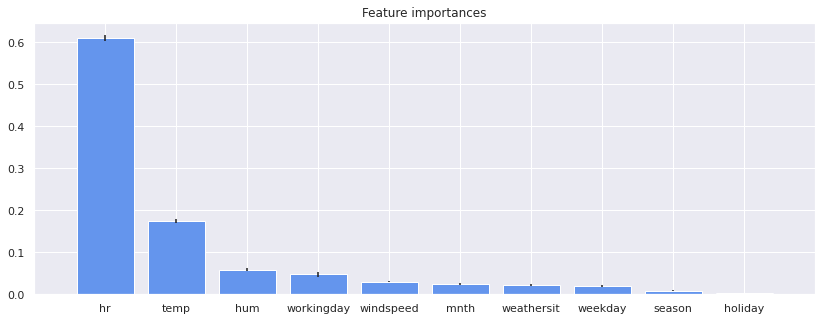

In [0]:
# Plot the feature importances of the forest
plt.figure(figsize=(14,5))
plt.title("Feature importances")
plt.bar(range(x_val.shape[1]), importances[indices], color="cornflowerblue", yerr=std[indices], align="center")
plt.xticks(range(x_val.shape[1]), [features[i] for i in indices])
plt.xlim([-1, x_val.shape[1]])
plt.show()

__Interpretation:__ The result corresponds to the high correlation of the hour and temperature variable with the bicycle sharing count in the feature correlation matrix.